DESCRIPTION

Using NLP and machine learning, make a model to identify toxic comments from the Talk edit pages on Wikipedia. Help identify the words that make a comment toxic.

Problem Statement:  

Wikipedia is the world’s largest and most popular reference work on the internet with about 500 million unique visitors per month. It also has millions of contributors who can make edits to pages. The Talk edit pages, the key community interaction forum where the contributing community interacts or discusses or debates about the changes pertaining to a particular topic. 

Wikipedia continuously strives to help online discussion become more productive and respectful. You are a data scientist at Wikipedia who will help Wikipedia to build a predictive model that identifies toxic comments in the discussion and marks them for cleanup by using NLP and machine learning. Post that, help identify the top terms from the toxic comments. 

Domain: Internet

Analysis to be done: Build a text classification model using NLP and machine learning that detects toxic comments.

Content: 

id: identifier number of the comment

comment_text: the text in the comment

toxic: 0 (non-toxic) /1 (toxic)

Steps to perform:

Cleanup the text data, using TF-IDF convert to vector space representation, use Support Vector Machines to detect toxic comments. Finally, get the list of top 15 toxic terms from the comments identified by the model.

Tasks: 


















1






In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from gensim.utils import simple_preprocess

# 1> Load the data using read_csv function from pandas package

In [72]:
data = pd.read_csv("C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course4-NLP/Projects/train.csv")
data.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0


In [3]:
data.toxic.value_counts(normalize=True)
# data is not balanced

0    0.9126
1    0.0874
Name: toxic, dtype: float64

In [4]:
data.comment_text.sample().values[0]

'"\r\nI replied on my talk page, I\'m getting tired, and doing that diff thing is tiring.— dαlus Contribs "'

# 2> Get the comments into a list, for easy text cleanup and manipulation

In [5]:
data1 = data.comment_text.values
len(data1)

5000

In [6]:
data1[:5]

array(['"\r\n\r\n A barnstar for you! \r\n\r\n  The Defender of the Wiki Barnstar I like your edit on the Kayastha page. Lets form a solidarity group against those who malign the article and its subject matter. I propose the folloing name for the group.\r\n\r\nUnited intellectuals\' front of Kayastha ethinicty against racist or castist abuse (UIFKEARCA)   "',
       '"\r\n\r\nThis seems unbalanced.  whatever I have said about Mathsci, he has said far more extreme and unpleasant things about me (not to mention others), and with much greater frequency.  I\'m more than happy to reign myself in, if that\'s what you\'d like (ruth be told, I was just trying to get Mathsci to pay attention and stop being uncivil).  I would expect you to issue the same request to Mathsci.  \r\n\r\n If this is intentionally unbalanced (for whatever reason), please let me know, and I will voluntarily close this account and move on to other things.  I like wikipedia, and I have a lot to contribute in my own way, 

# 3> Cleanup: 

    - Using regular expressions, remove IP addresses

    - Using regular expressions, remove URLs

    - Normalize the casing

    - Tokenize using word_tokenize from NLTK

    - Remove stop words

    - Remove punctuation

In [73]:
# removing IP addresses and numbers followed by "'s".

data2=[re.sub("((\d|\s)+\.)*","", sh) for sh in data1] # matches 0 or more of one or more digits followed by a period
data3=[re.sub("((\d|\s)+\'s)*","", sh) for sh in data2]
data3[124]
data3[516]

'Now amended.2'

In [74]:
data4=[re.sub("\w+://\S+","", sh) for sh in data3] # remove URLs
#data4[1673]
#data4[4704]
data4[4702]

"\r\n\r\nHere he is, your decision to block me for one week or even more is fully justified as i abused a particular religion,nation and a user but my acts of putting those articles on the list of deletion were correct and justified, i have never removed a single para which has been cited alongside citations and further as i know India's History closely i can surely claim all those articles as myth and simply hoax. And the agreement of another Editor and Admin who too is from Europe but unlike you he based him opinion after going through the articles which are without A single source for many years, when even after searching so much on net we cant find a single source then the article qualifies for deletion but admin like you insist on such articles.You havent told me a single reason that why those articles should be maintained on wikipedia(apart from your personal rivalry against me)."

In [75]:
data5=[sh.lower() for sh in data4] # Normalize the casing
data5[4714]

"you love osama bin laden so don't deny!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"

In [76]:
from nltk.tokenize import word_tokenize
data_tokens = [word_tokenize(sent) for sent in data5] # Tokenize using word_tokenize from NLTK
print(data_tokens[0])

['``', 'a', 'barnstar', 'for', 'you', '!', 'the', 'defender', 'of', 'the', 'wiki', 'barnstar', 'i', 'like', 'your', 'edit', 'on', 'the', 'kayastha', 'page', '.', 'lets', 'form', 'a', 'solidarity', 'group', 'against', 'those', 'who', 'malign', 'the', 'article', 'and', 'its', 'subject', 'matter', '.', 'i', 'propose', 'the', 'folloing', 'name', 'for', 'the', 'group', '.', 'united', 'intellectuals', "'", 'front', 'of', 'kayastha', 'ethinicty', 'against', 'racist', 'or', 'castist', 'abuse', '(', 'uifkearca', ')', '``']


In [188]:
from nltk.corpus import stopwords # removing stopwords and punctuations
from string import punctuation

stop_nltk = stopwords.words("english")
stop_punct = list(punctuation)

stop_punct.extend(['...','``',"''","..","$"])

stop_context = ['rt', 'amp','wikipedia','page','edit']

stop_final = stop_nltk + stop_punct + stop_context

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_final] for doc in texts]

data_words = remove_stopwords(data_tokens)
# print(data_words[0])
#print(data_words[4693])
#print(data_words[4639])
#print(data_words[4653])
#print(data_words[4751])
#print(data_words[4309])
print(data_words[826])

['xad', 'xad', 'yeah', 'revert', 'conformist']


In [277]:
len(data_words)

5000

# 4> Using a counter, find the top terms in the data. 

    - Can any of these be considered contextual stop words? 

    - Words like “Wikipedia”, “page”, “edit” are examples of contextual stop words

    - If yes, drop these from the data

In [12]:
from collections import Counter
term_list = []
for sh1 in data_words:
    term_list.extend(sh1)
    
res = Counter(term_list)
res.most_common(10)

[('article', 1735),
 ('talk', 1235),
 ('please', 1042),
 ('would', 1009),
 ('ass', 990),
 ('fuck', 908),
 ('one', 881),
 ('like', 845),
 ('also', 657),
 ('see', 632)]

In [13]:
# drop “Wikipedia”, “page”, “edit” from the data
del res['wikipedia'] 
del res['page'] 
del res['edit'] 
res.most_common(10)

[('article', 1735),
 ('talk', 1235),
 ('please', 1042),
 ('would', 1009),
 ('ass', 990),
 ('fuck', 908),
 ('one', 881),
 ('like', 845),
 ('also', 657),
 ('see', 632)]

In [243]:
'''char_list=['wikipedia','page','edit']
data_words = [ele for ele in data_words if all(ch not in ele for ch in char_list)] 
data_words'''

[['marya',
  'dzmitruk',
  'born',
  'minsk',
  'belarus',
  'march',
  'mother',
  'olga',
  'nikolaevna',
  'moroz',
  'born',
  'baranovichi',
  'belarus',
  'father',
  'born',
  'brest',
  'belarus',
  'second',
  'child',
  'family',
  'parents',
  'divorced',
  'soon',
  'father',
  'remarried',
  'two',
  'children',
  'marya',
  'age',
  'began',
  'gymnastics',
  'quit',
  'two',
  'years',
  'later',
  'denied',
  'medal',
  'competition',
  'age',
  'incorrectly',
  'marked',
  'turned',
  'years',
  'old',
  'got',
  'admitted',
  'music',
  'school',
  'minsk',
  'class',
  'violin',
  'public',
  'school',
  'piano',
  'classes',
  'main',
  'course',
  'age',
  'marya',
  'starred',
  'belarusfilm',
  'movie',
  'called',
  'dunechka',
  'soon',
  'started',
  'play',
  'theatre',
  'featured',
  'television',
  'shows',
  'mother',
  'decided',
  'move',
  'united',
  'states',
  'september',
  'marya',
  'went',
  'first',
  'american',
  'school',
  'ingrid',
  'lacy

# 5> Separate into train and test sets

    - Use train-test method to divide your data into 2 sets: train and test

    - Use a 70-30 split


In [78]:
# Join the tokens back into strings
data_clean = [" ".join(s) for s in data_words]
data_clean[0]

'barnstar defender wiki barnstar like kayastha lets form solidarity group malign article subject matter propose folloing name group united intellectuals front kayastha ethinicty racist castist abuse uifkearca'

In [79]:
print(len(data_clean))
print(len(data.toxic))

5000
5000


In [80]:
X=data_clean
y=data.toxic.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

# 6> Use TF-IDF values for the terms as feature to get into a vector space model

    - Import TF-IDF vectorizer from sklearn

    - Instantiate with a maximum of 4000 terms in your vocabulary

    - Fit and apply on the train set

    - Apply on the test set

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer # creating Document Term Matrix
vectorizer = TfidfVectorizer(max_features = 4000)
len(X_train), len(X_test)

(3500, 1500)

In [225]:
X_train_bow = vectorizer.fit_transform(X_train)

X_test_bow = vectorizer.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((3500, 4000), (1500, 4000))

In [227]:
print ("Num words:", len(vectorizer.get_feature_names()))

Num words: 4000


# 7> Model building: Support Vector Machine

    - Instantiate SVC from sklearn with a linear kernel

    - Fit on the train data

    - Make predictions for the train and the test set


In [83]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear',random_state=8) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train_bow, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_bow)

# 8> Model evaluation: Accuracy, recall, and f1_score

    - Report the accuracy on the train set

    - Report the recall on the train set:decent, high, low?

    - Get the f1_score on the train set

In [84]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9493333333333334


I got a classification rate of 94.9%, considered as very good accuracy.

In [85]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labeled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.9672131147540983
Recall: 0.44360902255639095


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1365    2]
 [  74   59]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1367
           1       0.97      0.44      0.61       133

    accuracy                           0.95      1500
   macro avg       0.96      0.72      0.79      1500
weighted avg       0.95      0.95      0.94      1500



# 9> Looks like you need to adjust  the class imbalance, as the model seems to focus on the 0s

    - Adjust the appropriate parameter in the SVC module

In [87]:
clf1 = svm.SVC(kernel='linear', 
            class_weight='balanced') # penalize
            #probability=True,
               #C=1.0)
 
clf1.fit(X_train_bow, y_train)
 
# Predict on training set
y_pred1 = clf1.predict(X_test_bow)
 
# Is our model still predicting just one class?
print( np.unique( y_pred1 ) )
# [0 1]
 
# How's our accuracy?
print( metrics.accuracy_score(y_test, y_pred1) )

[0 1]
0.938


# 10> Train again with the adjustment and evaluate

    - Train the model on the train set

    - Evaluate the predictions on the validation set: accuracy, recall, f1_score

In [88]:
# Model Recall: what percentage of positive tuples are labeled as such?
print("Recall:",metrics.recall_score(y_test, y_pred1))

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

Recall: 0.6390977443609023
[[1322   45]
 [  48   85]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1367
           1       0.65      0.64      0.65       133

    accuracy                           0.94      1500
   macro avg       0.81      0.80      0.81      1500
weighted avg       0.94      0.94      0.94      1500



# 11> Hyperparameter tuning

    - Import GridSearch and StratifiedKFold (because of class imbalance)

    - Provide the parameter grid to choose for ‘C’

    - Use a balanced class weight while instantiating the Support Vector Classifier

Grid Search Cross Validation
We first need to define the grid:

In [89]:
# C :-Penalty parameter C of the error term
C = [.0001, .001, .01]

# gamma :- Kernel coefficient.
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree :- Degree of the polynomial kernel function.
degree = [1, 2, 3, 4, 5]

# kernel :- Specifies the kernel type to be used in the algorithm.
kernel = ['linear']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear'],
 'probability': [True]}


In [26]:
#  - Choose stratified 5 fold cross validation scheme

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X_train, y_train):
    print('train -  {}   |   test -  {}'.format(np.bincount(y_train), np.bincount(y_test)))

train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]


Then, we'll perform the Grid Search:

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score,recall_score

scoring = { 'Recall': make_scorer(recall_score)}
# 'precision': make_scorer(precision_score),

# First create the base model to tune
svc = svm.SVC(random_state=8)

grid_search = GridSearchCV(estimator=svc, 
                           param_grid=random_grid,
                           scoring=scoring,
                           #cv=skf,
                           refit=False,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_bow, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:  8.5min finished


GridSearchCV(estimator=SVC(random_state=8),
             param_grid={'C': [0.0001, 0.001, 0.01], 'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear'], 'probability': [True]},
             refit=False, scoring={'Recall': make_scorer(recall_score)},
             verbose=1)

In [ ]:
# Definition of the random search
'''random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=skf, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train_bow, y_train)'''

We can see the best hyperparameters resulting from the Random Search:

In [33]:

print("The best hyperparameters from Grid Search are:")
#print(random_search.best_params_)
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

After that, we can do a more exhaustive search centered in those values:

Grid Search Cross Validation

In [203]:
#from sklearn.model_selection import ShuffleSplit
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly','linear'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf','linear'], 'gamma':gamma, 'probability':probability}
]

# C :-Penalty parameter C of the error term
#C = [.0001, .001, .01]

# gamma :- Kernel coefficient.
#gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree :- Degree of the polynomial kernel function.
#degree = [1, 2, 3, 4, 5]

# kernel :- Specifies the kernel type to be used in the algorithm.
#kernel = ['linear']

# probability
#probability = [True]

# Create the random grid
#random_grid = {'C': C,
#              'kernel': kernel,
#              #'gamma': gamma,
#              #'degree': degree,
#              'probability': probability
#             }

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
#cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

#from sklearn.metrics import precision_score,recall_score
#scoring = { 'Recall': make_scorer(recall_score)}
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X_train, y_train):
    print('train -  {}   |   test -  {}'.format(np.bincount(y_train), np.bincount(y_test)))
    
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid= param_grid,
                           #random_grid,
                           scoring='accuracy',
                           cv=skf,
                           #refit=False,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_bow, y_train)

train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
Fitting 5 folds for each of 52 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 641.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(random_state=8),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly', 'linear'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf', 'linear'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

The best hyperparameters turn out to be:

In [198]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9168831168831169


Let's save the model in best_svc:

In [199]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

We now know the best SVM model. Let's fit it and see how it performs:
Model fit and performance
Now, we can fit the model to our training data:

In [200]:
best_svc.fit(X_train_bow, y_train)
svc_pred = best_svc.predict(X_test_bow)
#random_search.fit(X_train_bow, y_train)
# And get the predictions:
#svc_pred = random_search.predict(X_test_bow)

The conditional class probabilities can be obtained by typing:

svc_pred = best_svc.predict_proba(X_test_bow)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

Training accuracy

In [201]:
# Training accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
print("The training accuracy is: ")
print(accuracy_score(y_train, best_svc.predict(X_train_bow)))
print("The training recall is: ")
print(recall_score(y_train, best_svc.predict(X_train_bow)))
#print(accuracy_score(y_train, random_search.predict(X_train_bow)))
#print("The training recall is: ")
#print(recall_score(y_train, random_search.predict(X_train_bow)))

The training accuracy is: 
0.9194285714285715
The training recall is: 
0.07236842105263158


In [202]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, svc_pred))
print("The test recall is: ")
print(recall_score(y_test, svc_pred))

The test accuracy is: 
0.918
The test recall is: 
0.07518796992481203


In [113]:
# Classification report
print("Classification report")
print(classification_report(y_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1367
           1       1.00      0.08      0.14       133

    accuracy                           0.92      1500
   macro avg       0.96      0.54      0.55      1500
weighted avg       0.92      0.92      0.88      1500



Let's see if the hyperparameter tuning process has returned a better model:

In [117]:
'''base_model = svm.SVC(random_state = 8)
base_model.fit(X_train_bow, y_train)
accuracy_score(y_test, base_model.predict(X_test_bow))
recall_score(y_test, base_model.predict(X_test_bow))

0.9333333333333333

In [118]:
'''best_svc.fit(X_train_bow, y_train)
accuracy_score(y_test, best_svc.predict(X_test_bow))
recall_score(y_test, best_svc.predict(X_test_bow))

0.918

We'll create a dataset with a model summary to compare models:

# 12> Find the parameters with the best recall in cross validation

    - Choose ‘recall’ as the metric for scoring

In [114]:
from sklearn.metrics import recall_score
d = {
     'Model': 'SVM',
     'Training Set recall': recall_score(y_train, best_svc.predict(X_train_bow)),
     'Test Set recall': recall_score(y_test, best_svc.predict(X_test_bow))
}

df_models_svc = pd.DataFrame(d, index=[0])

In [115]:
df_models_svc

,Model,Training Set recall,Test Set recall
0,SVM,0.072368,0.075188


In [169]:
'''from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
#>>> X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X_train, y_train):
    print('train -  {}   |   test -  {}'.format(np.bincount(y_train), np.bincount(y_test)))
    
    base_model.fit(X_train, y_train)
#print("------------------------------------------------------------------------------")
#kf = KFold(n_splits=5)
#for train, test in kf.split(X_train_bow, y_train):
#    print('train -  {}   |   test -  {}'.format(np.bincount(y_train), np.bincount(y_test)))

train -  [3651  349]   |   test -  [912  88]


ValueError: Found input variables with inconsistent numbers of samples: [3500, 4000]

In [147]:
'''from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
X=data_clean
X=np.array(X)
y=data.toxic.values
y=np.array(y)
for train_index, val_index in skf.split(X,y): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train=np.array(X_train)
    X_test= np.array(X_test) 
    X_train,X_test= X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]'''

Train: [ 931  937  959 ... 4997 4998 4999] Validation: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  

Train: [   0    1    2 ... 4997 4998 4999] Validation: [1791 1794 1824 1851 1858 1872 1876 1880 1897 1906 1916 1963 1971 1979
 2009 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111
 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125
 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139
 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153
 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167
 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181
 2182 2183 2184 2185 2

Train: [   0    1    2 ... 4012 4013 4014] Validation: [3872 3876 3883 3892 3920 3930 3946 3957 3958 3967 3976 3983 3986 3993
 3999 4015 4016 4017 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027
 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041
 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055
 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069
 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083
 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097
 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111
 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125
 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139
 4140 4141 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153
 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167
 4168 4169 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181
 4182 4183 4184 4185 4

In [158]:
#grid_search = GridSearchCV(estimator=svc, 
#                           param_grid=param_grid,
#                           scoring='accuracy',
#                           cv=skf,
#                           verbose=1)

# Fit the grid search to the data
#grid_search.fit(X_train, y_train)
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(svc, X_train, y_train, cv=skf)

# 13> What are the best parameters?

In [116]:
# best_svc = grid_search.best_estimator_
best_svc


SVC(C=0.1, kernel='linear', probability=True, random_state=8)

# 14> Predict and evaluate using the best estimator

    - Use best estimator from the grid search to make predictions on the test set

    - What is the recall on the test set for the toxic comments?

    - What is the f1_score?

In [117]:
print(classification_report(y_test,best_svc.predict(X_test_bow)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1367
           1       1.00      0.08      0.14       133

    accuracy                           0.92      1500
   macro avg       0.96      0.54      0.55      1500
weighted avg       0.92      0.92      0.88      1500



training data:



<AxesSubplot:>

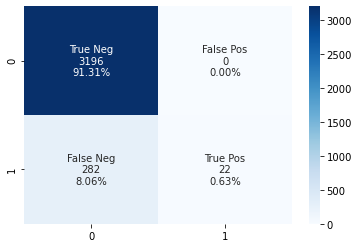

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm=confusion_matrix(y_train, best_svc.predict(X_train_bow))
#cmd = ConfusionMatrixDisplay(cm, display_labels=['toxic(0)','non-toxic(1)'])
print("training data:\n")
#cmd.plot()

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

testing data:



<AxesSubplot:>

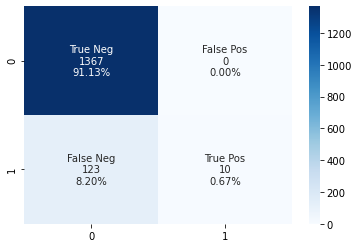

In [129]:
cm1=confusion_matrix(y_test,best_svc.predict(X_test_bow))
#cmd1 = ConfusionMatrixDisplay(cm1, display_labels=['toxic(0)','non-toxic(1)'])
print("testing data:\n")
#cmd1.plot()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')

In [211]:
#best_svc.coef_
best_svc.classes_
#clf.coef_[0]

array([0, 1], dtype=int64)

In [217]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [220]:
print_top10(X_train_bow, best_svc, best_svc.classes_)

AttributeError: get_feature_names not found

In [228]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [237]:
from sklearn import svm
import pandas as pd
import numpy as np 

from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

x=X.toarray()
y=[0,0,0,1]

model=svm.SVC(kernel='linear')

a=model.fit(x,y)
model.score(x,y)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')

,coefficient,word
0,-0.000261,second
1,-0.000156,and
2,-0.000156,one
3,-0.000156,third
4,-0.000104,document
5,0.000000,is
6,0.000000,the
7,0.000000,this
8,0.000417,first


In [232]:
show_most_informative_features(vectorizer,best_svc,n=20)

TypeError: must be real number, not csr_matrix

In [233]:
def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    print("Important words in negative reviews")

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print("-----------------------------------------")
    print("Important words in positive reviews")

    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)


In [234]:
important_features(vectorizer,best_svc,n=20)

AttributeError: 'SVC' object has no attribute 'feature_count_'

# 15> What are the most prominent terms in the toxic comments?

    - Separate the comments from the test set that the model identified as toxic

    - Make one large list of the terms

    - Get the top 15 terms

In [167]:
# Indexes of the test set
#index_X_test = svc_pred.index
#index_X_test=np.where(svc_pred==0)
index_X_test=np.where(best_svc.predict(X_test_bow==0))

# We get them from the original df
data_words1=data_words
data_words1=pd.DataFrame(data_words1)
df_test = data_words1.loc[index_X_test]


# Add the predictions
predictions=best_svc.predict(X_test_bow)
df_test['toxic'] = predictions

ValueError: Length of values (1500) does not match length of index (10)

In [170]:
predict = best_svc.predict_proba(X_test_bow)
print(predict.shape)
predict

(1500, 2)


array([[0.99103676, 0.00896324],
       [0.94891339, 0.05108661],
       [0.984286  , 0.015714  ],
       ...,
       [0.96908904, 0.03091096],
       [0.9865048 , 0.0134952 ],
       [0.96311553, 0.03688447]])

In [166]:
len(df_test)

1435

In [154]:
data_words1

,0,1,2,3,4,5,6,7,8,9,...,702,703,704,705,706,707,708,709,710,711
0,barnstar,defender,wiki,barnstar,like,kayastha,lets,form,solidarity,group,...,None,None,None,None,None,None,None,None,None,None
1,seems,unbalanced,whatever,said,mathsci,said,far,extreme,unpleasant,things,...,None,None,None,None,None,None,None,None,None,None
2,marya,dzmitruk,born,minsk,belarus,march,mother,olga,nikolaevna,moroz,...,None,None,None,None,None,None,None,None,None,None
3,talkback,dear,celestia,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,new,categories,honestly,think,need,add,categories,move,characters,new,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,dildo,read,response,correctly,never,said,going,accuse,vandalism,said,...,None,None,None,None,None,None,None,None,None,None
4996,calm,calm,get,big,dick,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4997,opinion,dougweller,using,privileges,poorly,personal,attack,play,games,make,...,None,None,None,None,None,None,None,None,None,None
4998,style,section,expanded,remember,placed,tag,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [168]:
X_test_bow

<1500x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 30882 stored elements in Compressed Sparse Row format>

In [257]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

#Set Random seed
np.random.seed(500)

# Add the Data using pandas
Corpus = pd.read_csv(r"C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course4-NLP/Projects/train.csv",encoding='latin-1')

# Step - 1: Data Pre-processing - This will help in getting better results through the classification algorithms

# Step - 1a : Remove blank rows if any.
Corpus['comment_text'].dropna(inplace=True)

# Step - 1b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['comment_text'] = [entry.lower() for entry in Corpus['comment_text']]

# Step - 1c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['comment_text']= [word_tokenize(entry) for entry in Corpus['comment_text']]

# Step - 1d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


for index,entry in enumerate(Corpus['comment_text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

#print(Corpus['text_final'].head())
sh=Corpus[Corpus['toxic']==1]
# Step - 2: Split the model into Train and Test Data set
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],sh,test_size=0.3)

# Step - 3: Label encode the target variable  - This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

# Step - 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)




ValueError: Found input variables with inconsistent numbers of samples: [5000, 437]

In [256]:
sh=Corpus[Corpus['toxic']==1]
sh

,id,comment_text,toxic,text_final
7,f5bbfd1f588f1a53,"[loser, -, you, ca, n't, block, me, forever, y...",1,"['loser', 'ca', 'block', 'forever', 'admin', '..."
8,a238eb61fa81da30,"[you, can, not, block, me, ., if, you, block, ...",1,"['block', 'block', 'call', 'dumbhead']"
16,e5bf9fa72a64c334,"[theres, a, fucking, wiki, page, on, it, you, ...",1,"['there', 'fucking', 'wiki', 'page', 'insane',..."
21,6803afa9a0e0089b,"[fuck, off, you, ass, !, fuck, off, you, ass, ...",1,"['fuck', 'ass', 'fuck', 'ass', 'fuck', 'ass', ..."
23,e172f0e0098bb6e2,"[so, ,, are, you, a, christian, becaue, of, je...",1,"['christian', 'becaue', 'jesus', 'assyrian', '..."
...,...,...,...,...
4933,756081e7bbf6216e,"[oh, ,, come, on, ., the, guys, from, nodq, sa...",1,"['oh', 'come', 'guy', 'nodq', 'saw', 'taping',..."
4953,416fe6ad0a6765af,"[i, agree, with, sophy, 's, duckling, ., whoev...",1,"['agree', 'sophy', 'duckling', 'whoever', 'wri..."
4977,c8edda4d552730f1,"[sunshine, quit, being, such, an, asshole, sta...",1,"['sunshine', 'quit', 'asshole', 'state', 'fact..."
4985,98e4fcfa3aa4ad20,"[yes, ,, complain, to, your, rabbi, and, then,...",1,"['yes', 'complain', 'rabbi', 'go', 'shoot', 'd..."


In [186]:
Corpus['text_final'][826]
# print(data_words[4639])
#print(data_words[4653])
#print(data_words[4751])
#print(data_words[4309])
#print(data_words[826])

"['yeah', 'revert', 'edit', 'conformist']"

In [259]:
# Step - 5: Now we can run different algorithms to classify out data check for accuracy

# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)


# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

X = vectorizer.fit_transform(Train_X)
#X = vectorizer.fit_transform(Corpus['text_final'])

x=X.toarray()
#y=[0,0,0,1]

#model=svm.SVC(C=0.1, kernel='linear', probability=True, random_state=80)

a=SVM.fit(x,Train_Y)
SVM.score(x,Train_Y)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')
df.head(15)

Naive Bayes Accuracy Score ->  92.0
SVM Accuracy Score ->  93.86666666666666


,coefficient,word
0,-0.086993,mother
1,-0.069249,photograph
2,-0.065923,sean
3,-0.061238,mein
4,-0.060078,wnba
5,-0.057697,sustainability
6,-0.057540,xxxx
7,-0.056253,truth
8,-0.053499,wolf
9,-0.051720,keyboard


In [250]:
X1= vectorizer.transform(Test_X)

x=X1.toarray()

#model=svm.SVC(C=0.1, kernel='linear', probability=True, random_state=80)

#a=model.fit(x,y_test)
SVM.score(x,Test_Y)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient',ascending=False)
df.head(15)

,coefficient,word
0,-0.086993,mother
1,-0.069249,photograph
2,-0.065923,sean
3,-0.061238,mein
4,-0.060078,wnba
5,-0.057697,sustainability
6,-0.057540,xxxx
7,-0.056253,truth
8,-0.053499,wolf
9,-0.051720,keyboard


In [238]:
from sklearn import svm
import pandas as pd
import numpy as np 

from sklearn.feature_extraction.text import CountVectorizer
#corpus = [
#    'This is the first document.',
#    'This document is the second document.',
#    'And this is the third one.',
#    'Is this the first document?']
corpus = data_clean
X=data_clean
y=data.toxic.values
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=62)
#from sklearn.feature_extraction.text import TfidfVectorizer # creating Document Term Matrix
vectorizer = TfidfVectorizer(max_features = 4000)
#X_train_bow = vectorizer.fit_transform(X_train)
#X_test_bow = vectorizer.transform(X_test)

#vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

x=X.toarray()
#y=[0,0,0,1]

model=svm.SVC(C=0.1, kernel='linear', probability=True, random_state=80)

a=model.fit(x,y)
model.score(x,y)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')

,coefficient,word
0,-0.111827,way
1,-0.109912,away
2,-0.095732,say
3,-0.088223,doubt
4,-0.088031,stand
...,...,...
3995,0.770046,shit
3996,0.827080,ass
3997,0.860763,suck
3998,1.757859,fucking


In [279]:
from sklearn import svm
import pandas as pd
import numpy as np 

from sklearn.feature_extraction.text import CountVectorizer

corpus = data_clean
X=data_clean
y=data.toxic.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=62)
from sklearn.feature_extraction.text import TfidfVectorizer # creating Document Term Matrix
vectorizer = TfidfVectorizer(max_features = 4000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

x=X_train_bow .toarray()

#model=svm.SVC(C=0.1, kernel='linear', probability=True, random_state=80)

#a=best_svc.fit(x,y_train)
best_svc.score(x,y_train)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(best_svc.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient',ascending=True)
df.head(15)

,coefficient,word
0,-0.101861,away
1,-0.095024,link
2,-0.089245,long
3,-0.086467,article
4,-0.078851,stand
5,-0.076729,fine
6,-0.075942,way
7,-0.074997,also
8,-0.071728,rfa
9,-0.070729,talkpage


In [280]:
best_svc.coef_[0]

array([-0.00970075,  0.        , -0.00792109, ...,  0.        ,
        0.        ,  0.        ])

In [278]:

#X_test_bow = vectorizer.transform(X_test)

x=X_test_bow .toarray()

#model=svm.SVC(C=0.1, kernel='linear', probability=True, random_state=80)

#a=model.fit(x,y_test)
best_svc.score(x,y_test)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(best_svc.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient',ascending=False)
df.head(15)

,coefficient,word
0,-0.101861,ben
1,-0.095024,light
2,-0.089245,loan
3,-0.086467,av
4,-0.078851,sonja
5,-0.076729,frustration
6,-0.075942,voter
7,-0.074997,anime
8,-0.071728,retire
9,-0.070729,sunday


In [271]:
res_df = pd.DataFrame({'word':X_test, 'toxic':y_test})

In [269]:
res_df[(res_df.toxic)==1].shape

(129, 2)

In [270]:
res_df[(res_df.toxic)==1]

,word,toxic
19,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
60,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
81,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
85,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
86,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
...,...,...
1426,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
1442,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
1457,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1
1495,"(0, 3834)\t0.2572190989240137\n (0, 3399)\t...",1


In [273]:
res_df1 = pd.DataFrame({'word':Test_X, 'toxic':Test_Y,'predictions':predictions_SVM})

In [274]:
res_df1

,word,toxic,predictions
2187,"['palestine', 'bc']",0,0
116,"['real', 'warning', 'enignaman', 'en', 'editor...",0,0
4973,"['oppose', 'reason', 'outline', 'would', 'rath...",0,0
834,"['doubt', 'doubt', 'first', 'need']",0,0
1370,"['december', 'utc', 'thanks', 'comment', 'talk...",0,0
...,...,...,...
4862,"['nope', 'take', 'look', 'wp', 'n', 'wp', 'mus...",0,0
4071,"['fuck', 'wikipedia', 'doosh', 'bag']",1,1
692,"['confuse', 'confuse', 'message', 'leave', 'ta...",0,0
4573,"['kind', 'bullshit', 'hamas', 'goal', 'free', ...",1,0


In [276]:
type(Corpus['comment_text'])

pandas.core.series.Series